In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import os
import requests
import json
import regex as re

import lib_sean

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
#  dir setting
root_dir = '\\'.join( os.getcwd().split('\\')[:-1])
data_dir = root_dir + '\\' + 'Data\\'

##### EDA - original set

In [3]:
df = pd.read_excel(data_dir + 'property_data.xlsx')
df_rev_geocoding = pd.read_excel(data_dir + 'rev_geocoding.xlsx')

In [4]:
df = lib_sean.clean_data(df, df_rev_geocoding)
df.rename(columns=lib_sean.col_renamer, inplace=True)
print(df.shape)

(102575, 23)


In [5]:
print(df.columns)
df.isna().sum().sort_values(ascending = False)[:10]

Index(['id', 'name', 'host_id', 'host_name', 'nyc_borough', 'neighborhood',
       'latitude', 'longitude', 'instant_bookable', 'cancellation_policy',
       'room_type', 'construction_year', 'price', 'service_fee',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'house_rules', 'coordinate', 'full_address',
       'zipcode', 'property_name'],
      dtype='object')


house_rules            52123
minimum_nights           408
host_name                406
zipcode                  312
cancellation_policy       74
nyc_borough               24
id                         0
service_fee                0
full_address               0
coordinate                 0
dtype: int64

In [6]:
df_by_neighbor = df.groupby(by = ['neighborhood']).agg(
    avg_price = pd.NamedAgg(column='price', aggfunc= 'mean'),
    avg_monthy_review = pd.NamedAgg(column='reviews_per_month', aggfunc= 'mean')
)
df_by_neighbor

,avg_price,avg_monthy_review
neighborhood,,
Allerton,636.23,2.04
Arden Heights,804.89,1.65
Arrochar,625.75,1.33
Arverne,652.13,1.51
Astoria,639.00,1.31
...,...,...
Windsor Terrace,579.92,1.29
Woodhaven,630.49,2.03
Woodlawn,587.14,2.40


- appeared that there is no relationship between rental price and monthly review, probably owing to the unwillingness of customers to give review.
- As a result, the review data is sparse and therefore invalid for drawing statistical conclusions

count    224.00
mean     622.51
std       96.31
min      107.67
25%      593.00
50%      626.86
75%      652.32
max     1045.00
Name: avg_price, dtype: float64


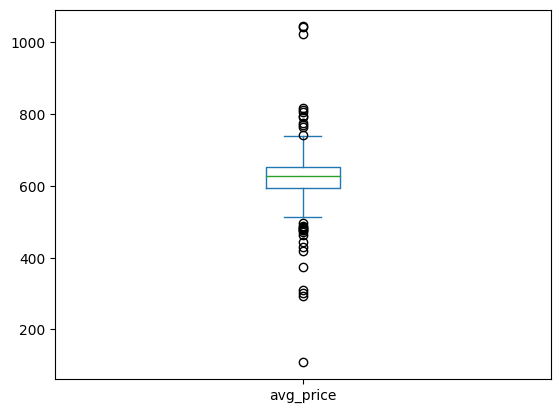

In [7]:
df_by_neighbor.avg_price.plot(kind='box')
print(df_by_neighbor.avg_price.describe())

- It can be concluded from the box plot that the rental price features low variance and is roughly of normal distribution. That way, average price could be a good index for pricing.

In [8]:
df_by_neighbor.avg_price.sort_values(ascending=False)[:10]

neighborhood
New Dorp                 1045.00
Chelsea, Staten Island   1042.00
Fort Wadsworth           1024.00
Little Neck               817.75
Jamaica Hills             812.90
Arden Heights             804.89
Midland Beach             796.18
Shore Acres               792.26
Mill Basin                775.14
Riverdale                 768.74
Name: avg_price, dtype: float64

In [9]:
# neighborhoods where working people dwell in -- according to GPT
df_by_neighbor.avg_price.sort_values(ascending=False)[['Astoria', 'Washington Heights', 'Park Slope', 'Long Island City', 'Williamsburg']]

neighborhood
Astoria              639.00
Washington Heights   602.20
Park Slope           607.81
Long Island City     647.36
Williamsburg         625.54
Name: avg_price, dtype: float64

In [10]:
# export cleaned dataset
#df.to_csv(data_dir + 'property_data_cleaned.csv')

##### EDA - Inside Airbnb NYC Listings
- take a look at the relationship between monthly price and daily price

In [11]:
df_ia = pd.read_csv(data_dir + 'Obsolute/listings.csv')
df_ia.rename(columns=lib_sean.col_renamer, inplace=True)
df_ia.shape

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_21048\3960604245.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ia = pd.read_csv(data_dir + 'Obsolute/listings.csv')


(42931, 18)

In [12]:
df_ia.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

##### EDA - Geographical set
- tour site data
    - looks good
    - can perform geographical analysis and visualization using this dataset

In [13]:
df_tour_site = pd.read_excel(data_dir + 'New_York_Tourist_Locations.xlsx')

C:\Users\Chaconne\AppData\Roaming\Python\Python310\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [14]:
df_tour_site.head(5)

,Tourist_Spot,Address,Zipcode
0,47th Street - The Diamond District,"47th St. betw. Fifth & Sixth Aves. Manhattan, ...",10036
1,9/11 Memorial & Museum,World Trade Center (museum: 180 Greenwich St.)...,10007
2,Abyssinian Baptist Church,"132 Odell Clark Place New York, NY 10030, Harlem",10030
3,Alice Austen House Museum,"2 Hylan Blvd. Staten Island, NY 10305, Staten ...",10305
4,Alice Tully Hall,"1941 Broadway Manhattan, NY 10023, Upper West ...",10023


##### EDA - DOF Summary of Neighborhood Sales by Neighborhood Citywide by Borough
    - Records sales of homes
    - rows are kind of few
    - many rows are out dated (records from around 10 years ago)
    - most recent records were from 2021. The dataset appears obsolute

In [15]:
df_cny_sale = pd.read_csv(data_dir + 'DOF__Summary_of_Neighborhood_Sales_by_Neighborhood_Citywide_by_Borough.csv')

In [16]:
df_cny_sale.shape

(7180, 9)

In [17]:
df_cny_sale.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'TYPE OF HOME', 'NUMBER OF SALES',
       'LOWEST SALE PRICE', 'AVERAGE SALE PRICE', 'MEDIAN SALE PRICE',
       'HIGHEST SALE PRICE', 'YEAR'],
      dtype='object')

In [18]:
df_cny_sale.NEIGHBORHOOD.value_counts()[:5]

SUNNYSIDE                   67
BOERUM HILL                 36
CLINTON HILL                36
FLATBUSH-NORTH              36
FLATBUSH-LEFFERTS GARDEN    36
Name: NEIGHBORHOOD, dtype: int64

In [19]:
df_cny_sale.YEAR.value_counts()

2021    615
2013    611
2015    607
2014    605
2016    604
2018    602
2019    598
2017    594
2012    592
2010    587
2020    586
2011    579
Name: YEAR, dtype: int64

##### EDA - Dataset: nyc property assessment data
    - comprehensive and with sufficient rows.
    - some columns' meaning are not yet understood.

In [20]:
df_assess_2023 = pd.read_csv(data_dir + 'nyc_property_assessment_data_2023.csv').drop(columns='Unnamed: 0')

C:\Users\Chaconne\AppData\Local\Temp\ipykernel_21048\244126032.py:1: DtypeWarning: Columns (1,5,6,9,10,23,34,67,71,74,75,76,88,93,100,101,105,109,111,133) have mixed types. Specify dtype option on import or set low_memory=False.
  df_assess_2023 = pd.read_csv(data_dir + 'nyc_property_assessment_data_2023.csv').drop(columns='Unnamed: 0')


In [21]:
df_assess_2023.shape

(1155828, 139)

In [22]:
df_assess_2023.columns

Index(['PARID', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'SUBIDENT-REUC', 'RECTYPE',
       'YEAR', 'IDENT', 'SUBIDENT',
       ...
       'STORAGE_AREA_GROSS', 'GARAGE_AREA', 'OTHER_AREA_GROSS',
       'REUC_DESCRIPTION', 'EXTRACRDT', 'PYTAXFLAG', 'TENTAXFLAG',
       'CBNTAXFLAG', 'FINTAXFLAG', 'CURTAXFLAG'],
      dtype='object', length=139)

In [23]:
df_assess_2023.BLD_STORY.value_counts()

2.00      537526
3.00      147660
0.00      119508
1.00       89363
4.00       46244
           ...  
1.15           1
13.50          1
102.00         1
706.00         1
114.00         1
Name: BLD_STORY, Length: 136, dtype: int64

##### EDA - Borough-wise sales data from https://www.nyc.gov/site/finance/taxes/property-rolling-sales-data.page

In [24]:
df_bkl = pd.read_excel(data_dir + 'rollingsales_brooklyn.xlsx')
df_brn = pd.read_excel(data_dir + 'rollingsales_bronx.xlsx')
df_mht = pd.read_excel(data_dir + 'rollingsales_manhattan.xlsx')
df_qns = pd.read_excel(data_dir + 'rollingsales_queens.xlsx')
df_sti = pd.read_excel(data_dir + 'rollingsales_statenisland.xlsx')

df_list = [df_bkl, df_brn, df_mht, df_qns, df_sti]

df_rs = pd.concat(df_list)

In [25]:
df_rs.shape

(84391, 21)

In [26]:
# check if concat is performed correctly 
col_same = True
comparer = df_list[0]
for i in range(1,5):
    col_same = col_same and all(comparer.columns == df_list[i].columns)
col_same

True

In [27]:
df_rs.rename(columns= lib_sean.col_renamer, inplace=True)
df_rs.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'easement',
       'building_class_at_present', 'address', 'apartment_number', 'zip_code',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_time_of_sale', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date'],
      dtype='object')

- the data contains sales of differet building categories. 
- Should drop categories that are not for rental business. For example, warehouse and office buildings.
- Should enlarge the granularity of the factors, i.e., to merge levels that refer to similar building types.

In [28]:
df_rs.building_class_category.value_counts()

01 ONE FAMILY DWELLINGS                       17173
02 TWO FAMILY DWELLINGS                       14993
13 CONDOS - ELEVATOR APARTMENTS               14382
10 COOPS - ELEVATOR APARTMENTS                14265
03 THREE FAMILY DWELLINGS                      4226
07 RENTALS - WALKUP APARTMENTS                 3004
09 COOPS - WALKUP APARTMENTS                   2778
15 CONDOS - 2-10 UNIT RESIDENTIAL              1604
04 TAX CLASS 1 CONDOS                          1543
44 CONDO PARKING                               1489
17 CONDO COOPS                                 1331
12 CONDOS - WALKUP APARTMENTS                   979
05 TAX CLASS 1 VACANT LAND                      931
22 STORE BUILDINGS                              790
14 RENTALS - 4-10 UNIT                          640
08 RENTALS - ELEVATOR APARTMENTS                505
47 CONDO NON-BUSINESS STORAGE                   465
29 COMMERCIAL GARAGES                           463
43 CONDO OFFICE BUILDINGS                       340
11 SPECIAL C

In [29]:
def is_non_commercial_building_category(category:str) -> bool:
    pat_commercial = r'LAND|WAREHOUSE|THEATRES|TRANSPORTATION|GOVERNMENTAL|STORE|FACTORIES|OFFICE|COMMERCIAL|PARKING|RELIGIOUS|ASYLUMS|FACILITIES'

    non_commercial = not re.search(pattern=pat_commercial, string=category)
    return non_commercial


filter_noncom_building_cate = filter(is_non_commercial_building_category, np.unique(df_rs.building_class_category.values))
noncom_building_cate = list(filter_noncom_building_cate)
noncom_building_cate

['01 ONE FAMILY DWELLINGS',
 '02 TWO FAMILY DWELLINGS',
 '03 THREE FAMILY DWELLINGS',
 '04 TAX CLASS 1 CONDOS',
 '06 TAX CLASS 1 - OTHER',
 '07 RENTALS - WALKUP APARTMENTS',
 '08 RENTALS - ELEVATOR APARTMENTS',
 '09 COOPS - WALKUP APARTMENTS',
 '10 COOPS - ELEVATOR APARTMENTS',
 '11 SPECIAL CONDO BILLING LOTS',
 '12 CONDOS - WALKUP APARTMENTS',
 '13 CONDOS - ELEVATOR APARTMENTS',
 '14 RENTALS - 4-10 UNIT',
 '15 CONDOS - 2-10 UNIT RESIDENTIAL',
 '17 CONDO COOPS',
 '25 LUXURY HOTELS',
 '26 OTHER HOTELS',
 '41 TAX CLASS 4 - OTHER',
 '42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC',
 '45 CONDO HOTELS',
 '47 CONDO NON-BUSINESS STORAGE',
 '48 CONDO TERRACES/GARDENS/CABANAS']

In [30]:
# filter out records of commercial buildings
df_rs = df_rs.loc[df_rs.building_class_category.map(lambda v: v in noncom_building_cate), :]
df_rs.shape

(78674, 21)

In [31]:
def merge_building_category(bc: str) -> str:
    pat_dwell = r'DWELLINGS'
    pat_cond = r'CONDOS'
    pat_apt = r'APARTMENTS'

    is_dwell = re.search(pattern=pat_dwell, string=bc)
    if is_dwell:
        return pat_dwell

    is_cond = re.search(pattern=pat_cond, string=bc) 
    if is_cond:
        return pat_cond
    
    is_apt = re.search(pattern=pat_apt, string=bc)
    if is_apt:
        return pat_apt 
        
    return 'OTHER'

# merge building categories of similar features into one
df_rs.building_class_category = df_rs.building_class_category.map(merge_building_category)
df_rs.building_class_category.value_counts()

DWELLINGS     36392
APARTMENTS    20552
CONDOS        18508
OTHER          3222
Name: building_class_category, dtype: int64

- There are recoreds with zero sale price which should be dropped.

In [32]:
df_rs.sale_price.value_counts()[:5]

0         22135
10          728
650000      470
750000      450
800000      425
Name: sale_price, dtype: int64

In [33]:
df_rs = df_rs[df_rs.sale_price != 0]
print(df_rs.shape)
df_rs.sale_price.dtype

(56539, 21)


dtype('int64')

In [34]:
df_rs.groupby(by =[ 'neighborhood', 'building_class_category']).agg(
    # column records the time frame of observed sales 
    time_range = pd.NamedAgg(column='sale_date', aggfunc= lambda col: (col.min(), col.max())),

    avg_price = pd.NamedAgg(column='sale_price', aggfunc= 'mean'),
)

time_range  \
neighborhood       building_class_category                                               
AIRPORT LA GUARDIA CONDOS                   (2022-07-26 00:00:00, 2023-03-27 00:00:00)   
                   DWELLINGS                (2022-06-24 00:00:00, 2022-09-23 00:00:00)   
ALPHABET CITY      APARTMENTS               (2022-04-01 00:00:00, 2023-03-15 00:00:00)   
                   CONDOS                   (2022-04-05 00:00:00, 2023-03-03 00:00:00)   
                   DWELLINGS                (2022-09-15 00:00:00, 2023-01-20 00:00:00)   
...                                                                                ...   
WOODSIDE           OTHER                    (2022-04-28 00:00:00, 2023-03-07 00:00:00)   
WYCKOFF HEIGHTS    APARTMENTS               (2022-05-24 00:00:00, 2023-02-10 00:00:00)   
                   CONDOS                   (2022-04-01 00:00:00, 2023-03-21 00:00:00)   
                   DWELLINGS                (2022-04-15 00:00:00, 2023-03-31 00:00:00)   
                   OTHER                    (2022-04-25 00:00:00, 2023-01-04 00:00:00)   

                                            avg_price  
neighborhood       building_class_category             
AIRPORT LA GUARDIA CONDOS                   455000.00  
                   DWELLINGS                836398.33  
ALPHABET CITY      APARTMENTS              2873755.54  
                   CONDOS                  1361257.00  
                   DWELLINGS               1133000.00  
...                                               ...  
WOODSIDE           OTHER                   1491000.00  
WYCKOFF HEIGHTS    APARTMENTS              1062518.52  
                   CONDOS                   762432.32  
                   DWELLINGS               1327256.78  
                   OTHER                   1516286.17  

[779 rows x 2 columns]

- export cleaned rolling sales dataset

In [35]:
df_rs.to_csv(data_dir + 'nyc_rolling_sales_merged.csv')

##### EDA - condo rental income from https://data.cityofnewyork.us/City-Government/DOF-Cooperative-Comparable-Rental-Income-Citywide-/myei-c3fa
- this dataset provides info regarding the rental income of rental properties in NYC
- could be used for forecasting future rental income
- also note that NOI (net operating income) is the most commonly used metric for evaluating rental property profitability
- first of all, drop rows having no neighborhood values

In [36]:
df_rental_income = pd.read_csv(data_dir + 'DOF_Condominium_Comparable_Rental_Income_in_NYC.csv')
print(df_rental_income.shape)
df_rental_income.rename(columns=lib_sean.col_renamer, inplace=True)
df_rental_income.dropna(axis=0, subset='neighborhood', how = 'any', inplace=True)

(28507, 61)


In [37]:
print(df_rental_income.neighborhood.isna().sum())
df_rental_income.columns

0


Index(['boro_block_lot', 'condo_section', 'address', 'neighborhood',
       'building_classification', 'total_units', 'year_built', 'gross_sqft',
       'estimated_gross_income', 'gross_income_per_sqft', 'estimated_expense',
       'expense_per_sqft', 'net_operating_income', 'full_market_value',
       'market_value_per_sqft', 'boro_block_lot_1', 'address_1',
       'neighborhood_1', 'building_classification_1', 'total_units_1',
       'year_built_1', 'gross_sqft_1', 'estimated_gross_income_1',
       'gross_income_per_sqft_1', 'estimated_expense_1', 'expense_per_sqft_1',
       'net_operating_income_1', 'full_market_value_1',
       'market_value_per_sqft_1', 'distance_from_condo_in_miles',
       'boro_block_lot_2', 'address_2', 'neighborhood_2',
       'building_classification_2', 'total_units_2', 'year_built_2',
       'gross_sqft_2', 'estimated_gross_income_2', 'gross_income_per_sqft_2',
       'estimated_expense_2', 'expense_per_sqft_2', 'net_operating_income_2',
       'full_mar

<AxesSubplot:ylabel='Frequency'>

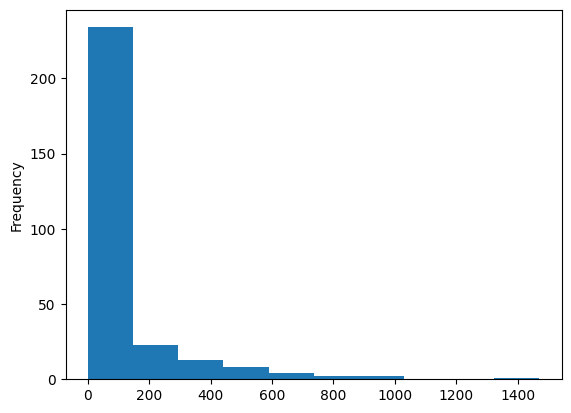

In [38]:
df_rental_income.neighborhood.value_counts().plot(kind = 'hist')

104.5


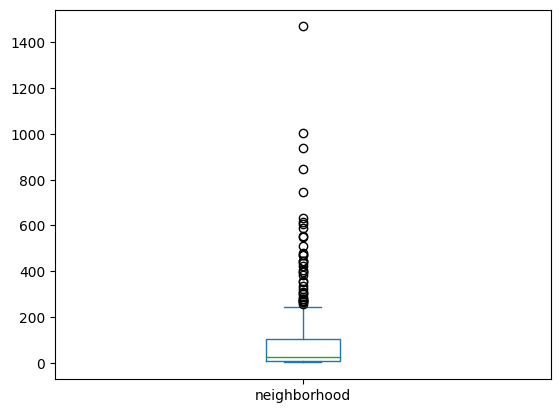

In [39]:
df_rental_income.neighborhood.value_counts().plot(kind = 'box')
print(df_rental_income.neighborhood.value_counts().quantile(q = 0.75))

- histogram of neighborhood value counts is of Pareto distribution.
- median of the distribution is 26 while upper quartile is 104
- use 100 as cutoff to filter out those neighborhoods whose frequency in the dataset is too low
- should thus drop those with rare frequency as in later phase we will do many aggregation operations

In [40]:
neighbor_to_freq = dict(df_rental_income.neighborhood.value_counts())

df_rental_income = df_rental_income.loc[
    df_rental_income.neighborhood.map(lambda n: neighbor_to_freq[n] >= 100), :
]
df_rental_income.shape

(23668, 61)

In [41]:
df_rental_income['unit_noi'] = df_rental_income.net_operating_income / df_rental_income.total_units

In [42]:
df_rental_income.report_year.value_counts().sort_index(ascending = False)[:5]

2021    1817
2020    2216
2019    2354
2018    2618
2017    2632
Name: report_year, dtype: int64

<AxesSubplot:title={'center':'Yearly Avg. NOI in Million'}, xlabel='report_year'>

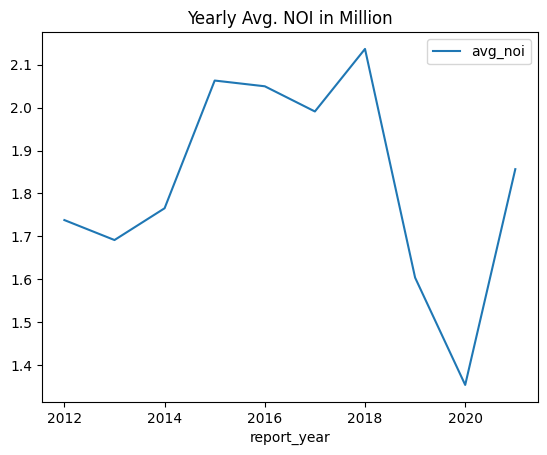

In [43]:
df_rental_income.groupby(by = ['report_year']).agg(
    avg_noi = pd.NamedAgg(column = 'net_operating_income', aggfunc = lambda c: c.mean() / 1000000),
).plot(kind = 'line', title='Yearly Avg. NOI in Million')

- 2020 saw a slump in NOI as the covid was prevailing. 
- the data in 2021 could serve as an estimate of NOI

<AxesSubplot:title={'center':'Yearly Avg. NOI by Unit'}, xlabel='report_year'>

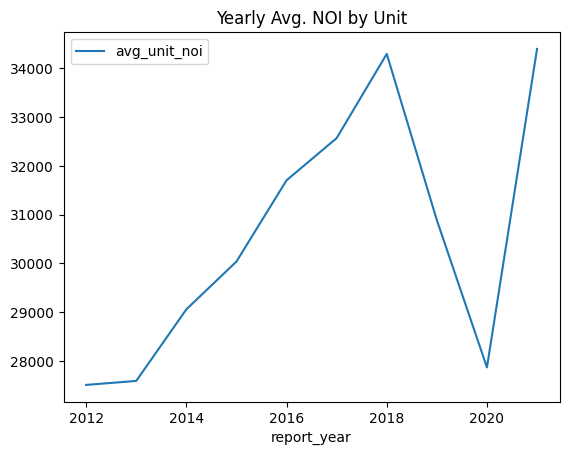

In [44]:
df_rental_income.groupby(by = ['report_year']).agg(
    avg_unit_noi = pd.NamedAgg(column = 'unit_noi', aggfunc = lambda c: c.mean()),
).plot(kind = 'line', title='Yearly Avg. NOI by Unit')

- can  say that the yearly average of unit NOI is somewhere around 37000

In [45]:
df_rental_income[df_rental_income.report_year == 2021].groupby(
        by = ['neighborhood']
    ).agg(
        avg_unit_noi = pd.NamedAgg(column = 'unit_noi', aggfunc = lambda c: c.mean())
    ).sort_values(
        ascending=False, by = 'avg_unit_noi'
    )[:10]

,avg_unit_noi
neighborhood,
SOHO,94277.41
FLATIRON,84896.23
TRIBECA,72987.15
CHELSEA,68379.66
UPPER EAST SIDE (59-79),62309.02
GRAMERCY,57727.41
FINANCIAL,55913.81
FASHION,48630.31
CLINTON,43073.69


In [46]:
df_rental_income[df_rental_income.report_year == 2021].groupby(by = ['boro_block_lot', 'neighborhood']).agg(
    avg_unit_noi = pd.NamedAgg(column = 'unit_noi', aggfunc = lambda c: c.mean())
).sort_values(ascending=False, by = 'avg_unit_noi')[:10]

,,avg_unit_noi
boro_block_lot,neighborhood,
1-01375-7504,UPPER EAST SIDE (59-79),429563.00
1-01389-7503,UPPER EAST SIDE (59-79),324028.91
3-02471-7501,WILLIAMSBURG-SOUTH,295801.00
3-01715-7503,BEDFORD STUYVESANT,273020.00
1-00490-7502,SOHO,252955.41
1-00512-7501,SOHO,252268.50
1-00766-7503,CHELSEA,247630.09
1-00875-7503,GRAMERCY,243036.75
1-00823-7503,FLATIRON,211708.55


##### EDA - Sentiment Analysis
- this is a dataset derived from the join of inside airbnb listings and inside airbnb reviews

In [52]:
df_sent = pd.read_csv(data_dir + 'reviews_sentiment_analysis.csv')
df_sent.rename(columns = lib_sean.col_renamer)
df_sent.listing_id = df_sent.listing_id.astype(int)
df_sent.id = df_sent.id.astype(int)
df_sent.shape

(530009, 7)

In [53]:
df_sent.head()

,listing_id,id,date,reviewer_id,sentiment_category,neighbourhood,avg_sentiment_category
0,15115382,581690116,12/25/2019,289984524,5,Woodside,4.02
1,15115382,591523348,1/11/2020,16177920,3,Woodside,4.02
2,15115382,595140562,1/19/2020,173362422,5,Woodside,4.02
3,15115382,595545885,1/20/2020,301401300,3,Woodside,4.02
4,15115382,597988500,1/26/2020,159226584,4,Woodside,4.02


In [54]:
df_sent.sentiment_category.describe()

count   530009.00
mean         3.98
std          0.67
min          1.00
25%          4.00
50%          4.00
75%          4.00
max          5.00
Name: sentiment_category, dtype: float64

In [68]:
df_ia_by_neighbor = df_ia.groupby(by = ['neighbourhood']).agg(
    avg_lng = pd.NamedAgg(column='longitude', aggfunc='mean'),
    avg_lat = pd.NamedAgg(column='latitude', aggfunc='mean'),
)


dict_nb_to_coord = {
    i.strip():(df_ia_by_neighbor.loc[i, 'avg_lng'], df_ia_by_neighbor.loc[i, 'avg_lat']) for i in df_ia_by_neighbor.index
}

In [73]:
def neighborhood_mapper(nb: str, is_latitude: bool) -> str:
    try:
        if is_latitude:
            res = dict_nb_to_coord[nb][1]
        else:
            res = dict_nb_to_coord[nb][0]
    except KeyError:
        return 'NA'


df_sent.neighbourhood = df_sent.neighbourhood.map(
    lambda n : n.strip().title()
)


df_sent['lng'] = df_sent.neighbourhood.map(
    lambda n: neighborhood_mapper(n, False)
)

df_sent['lat'] = df_sent.neighbourhood.map(
    lambda n: neighborhood_mapper(n, True)
)

In [72]:
df_sent[['lng', 'lat']]

,lng,lat
0,None,None
1,None,None
2,None,None
3,None,None
4,None,None
...,...,...
530004,NA,NA
530005,NA,NA
530006,NA,NA
530007,NA,NA


In [75]:
dict_nb_to_coord = {
    i.strip():(df_ia_by_neighbor.loc[i, 'avg_lng'], df_ia_by_neighbor.loc[i, 'avg_lat']) for i in df_ia_by_neighbor.index
}
dict_nb_to_coord

{'Allerton': (-73.8595842801977, 40.86503104079037),
 'Arden Heights': (-74.17536142795709, 40.55273400017838),
 'Arrochar': (-74.07242357142857, 40.59289785714286),
 'Arverne': (-73.79516428987976, 40.59297607901072),
 'Astoria': (-73.92044800814838, 40.764738865549056),
 'Bath Beach': (-74.00690111730648, 40.60527295221553),
 'Battery Park City': (-74.01641676756134, 40.70987986027279),
 'Bay Ridge': (-74.02581526603724, 40.63100669731867),
 'Bay Terrace': (-73.780484, 40.784802),
 'Baychester': (-73.84180317247231, 40.872363613791784),
 'Bayside': (-73.76963329784122, 40.7622024531169),
 'Bayswater': (-73.76324158181818, 40.605753331818185),
 'Bedford-Stuyvesant': (-73.93823030967107, 40.68705907161248),
 'Belle Harbor': (-73.848011235488, 40.57762882839039),
 'Bellerose': (-73.72821460140318, 40.72986081059013),
 'Belmont': (-73.88689897999677, 40.85433216703582),
 'Bensonhurst': (-73.9943253763846, 40.61236823944558),
 'Bergen Beach': (-73.91056710246905, 40.62512497511937),
 'Boe

In [76]:
df_sent.neighbourhood.value_counts()

Brooklyn                   335666
Queens                     122244
Bronx                       19425
Staten Island               11111
The Bronx                    9684
                            ...  
North Bronx (Wakefield)         3
Pomona                          2
Bushwick                        2
Little Neck                     1
Brooklyn Heights                1
Name: neighbourhood, Length: 91, dtype: int64